In [1]:
#pip install seaborn

In [1]:
from astropy.io import fits
from astropy.table import Table, join, unique
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['axes.titlesize'] = 14  # font size for plot titles
plt.rcParams['axes.labelsize'] = 12  # font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 10 # font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 10 # font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 10 # font size for legend

#file='../../astraAllStarASPCAP-0.6.0.fits'
#hdul=fits.open(file)
#header=hdul[2].header
#data=hdul[2].data
file='DR19_SeisAges_Sample_trainingVariation456789_cluster1819.fits'
hdul=fits.open(file)
header=hdul[1].header
data=hdul[1].data

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

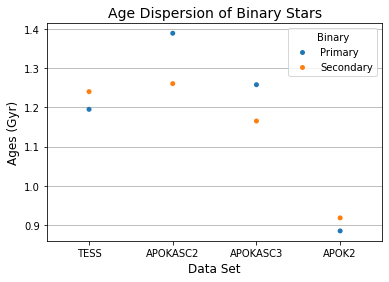

In [2]:


apogee_table = Table(data)
#apogee_table
# run^ to look for identifiers

# link to data: https://zenodo.org/records/4435257
# i selected: all_columns_catalog.fits.gz
# then unpacked
binary_file = 'all_columns_catalog.fits' # unzipped binary catalog
binaries = fits.open(binary_file)
binary_header = binaries[1].header
binary_data = binaries[1].data

binary_table = Table(binary_data)
binary_id = binary_table[['source_id1', 'source_id2']] # binary identifiers


#primary star mapping
primary = join(apogee_table, binary_table, keys_left='gaia_dr3_source_id', keys_right='source_id1', 
                           join_type='inner')
#secondary star mapping
secondary = join(apogee_table, binary_table, keys_left='gaia_dr3_source_id', keys_right='source_id2', 
                           join_type='inner')
wide_binaries = join(primary, secondary, keys=['source_id1', 'source_id2'], join_type='inner')

wide_binaries_data = wide_binaries[['tic_v8_id_1', 'source_id1', 'tic_v8_id_2', 'source_id2']] 
wide_binary = unique(wide_binaries_data, keys='source_id1')
wide_binary_table = wide_binary.to_pandas() # create a pandas dataframe of the wide binaries in the apogee catalog

# function to find the binary stars ages from each of the four methods, using the csv file of the age comparisons
def binary_matching(csv_file):
    tic_ages = pd.read_csv(csv_file)
    tic_identifier = tic_ages['TIC'].tolist()
    tic_binary = wide_binary_table[wide_binary_table['tic_v8_id_1'].isin(tic_identifier) & 
                                wide_binary_table['tic_v8_id_2'].isin(tic_identifier)].copy() # check tic numbers
    tic_binary = tic_binary[tic_binary['tic_v8_id_1'] != -1] # got a bunch of -1s for some reason, get rid of them
    merge1 = pd.merge(tic_binary, tic_ages, left_on='tic_v8_id_1', right_on='TIC', how='left')
    merge2 = pd.merge(merge1, tic_ages, left_on='tic_v8_id_2', right_on='TIC', how='left')
    merge2.rename(columns=lambda x: x.replace('_x', '_1').replace('_y', '_2'), inplace=True) # change suffix
    return merge2

tess_apokasc2 = binary_matching('TESS_APOKASC2_Comparison.csv')
tess_apokasc3 = binary_matching('TESS_APOKASC3_Comparison.csv')
tess_apok2 = binary_matching('TESS_APOK2_Comparison.csv')

#age selection
primary_tess_age = (tess_apokasc2['TESS_predicted_Gyr_1'][0] + tess_apokasc3['TESS_predicted_Gyr_1'][0] + 
                    tess_apok2['TESS_predicted_Gyr_1'][0])/3 # averaged the tess ages
secondary_tess_age = (tess_apokasc2['TESS_predicted_Gyr_2'][0] + tess_apokasc3['TESS_predicted_Gyr_2'][0] + 
                    tess_apok2['TESS_predicted_Gyr_2'][0])/3
primary_apokasc2_age = tess_apokasc2['APOKASC2_predicted_Gyr_1'][0]
secondary_apokasc2_age = tess_apokasc2['APOKASC2_predicted_Gyr_2'][0]
primary_apokasc3_age = tess_apokasc3['APOKASC3_predicted_Gyr_1'][0]
secondary_apokasc3_age = tess_apokasc3['APOKASC3_predicted_Gyr_2'][0]
primary_apok2_age = tess_apok2['APOK2_predicted_Gyr_1'][0]
secondary_apok2_age = tess_apok2['APOK2_predicted_Gyr_2'][0]

# create a data frame of the ages, star, and method
ages = {
    'Set': ['TESS', 'TESS', 'APOKASC2', 'APOKASC2', 'APOKASC3', 'APOKASC3', 'APOK2', 'APOK2'],
    'Binary': ['Primary', 'Secondary', 'Primary', 'Secondary', 'Primary', 'Secondary', 'Primary', 'Secondary'],
    'Ages': [primary_tess_age, secondary_tess_age, primary_apokasc2_age, secondary_apokasc2_age, primary_apokasc3_age, 
             secondary_apokasc3_age, primary_apok2_age, secondary_apok2_age]
}
ages_table = pd.DataFrame(ages)

plt.figure()
sns.stripplot(data=ages_table, x='Set', y='Ages', hue='Binary', dodge=False, jitter=False)
plt.ylabel('Ages (Gyr)')
plt.xlabel('Data Set')
plt.title('Age Dispersion of Binary Stars')
plt.grid(True, axis='y')
plt.show()

#tess yields least dispersion

In [3]:
primary

sdss_id,sdss4_apogee_id,gaia_dr2_source_id,gaia_dr3_source_id,tic_v8_id,healpix,lead,version_id,catalogid,catalogid21,catalogid25,catalogid31,n_associated,n_neighborhood,sdss5_target_flags,sdss4_apogee_target1_flags,sdss4_apogee_target2_flags,sdss4_apogee2_target1_flags,sdss4_apogee2_target2_flags,sdss4_apogee2_target3_flags,sdss4_apogee_member_flags,sdss4_apogee_extra_target_flags,ra,dec,l,b,plx,e_plx,pmra,e_pmra,pmde,e_pmde,gaia_v_rad,gaia_e_v_rad,g_mag,bp_mag,rp_mag,j_mag,e_j_mag,h_mag,e_h_mag,k_mag,e_k_mag,ph_qual,bl_flg,cc_flg,w1_mag,e_w1_mag,w1_flux,w1_dflux,w1_frac,w2_mag,e_w2_mag,w2_flux,w2_dflux,w2_frac,w1uflags,w2uflags,w1aflags,w2aflags,mag4_5,d4_5m,rms_f4_5,sqf_4_5,mf4_5,csf,zgr_teff,zgr_e_teff,zgr_logg,zgr_e_logg,zgr_fe_h,zgr_e_fe_h,zgr_e,zgr_e_e,zgr_plx,zgr_e_plx,zgr_teff_confidence,zgr_logg_confidence,zgr_fe_h_confidence,zgr_ln_prior,zgr_chi2,zgr_quality_flags,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,bailer_jones_flags,ebv,e_ebv,ebv_flags,ebv_zhang_2023,e_ebv_zhang_2023,ebv_sfd,e_ebv_sfd,ebv_rjce_glimpse,e_ebv_rjce_glimpse,ebv_rjce_allwise,e_ebv_rjce_allwise,ebv_bayestar_2019,e_ebv_bayestar_2019,ebv_edenhofer_2023,e_ebv_edenhofer_2023,c_star,u_jkc_mag,u_jkc_mag_flag,b_jkc_mag,b_jkc_mag_flag,v_jkc_mag,v_jkc_mag_flag,r_jkc_mag,r_jkc_mag_flag,i_jkc_mag,i_jkc_mag_flag,u_sdss_mag,u_sdss_mag_flag,g_sdss_mag,g_sdss_mag_flag,r_sdss_mag,r_sdss_mag_flag,i_sdss_mag,i_sdss_mag_flag,z_sdss_mag,z_sdss_mag_flag,y_ps1_mag,y_ps1_mag_flag,n_boss_visits,boss_min_mjd,boss_max_mjd,n_apogee_visits,apogee_min_mjd,apogee_max_mjd,source,star_pk,spectrum_pk,release,filetype,apred,apstar,obj,telescope,field,prefix,min_mjd,max_mjd,n_entries,n_visits,n_good_visits,n_good_rvs,snr,mean_fiber,std_fiber,spectrum_flags,v_rad,e_v_rad,std_v_rad,median_e_v_rad,doppler_teff,doppler_e_teff,doppler_logg,doppler_e_logg,doppler_fe_h,doppler_e_fe_h,doppler_rchi2,doppler_flags,xcorr_v_rad,xcorr_v_rel,xcorr_e_v_rel,ccfwhm,autofwhm,n_components,task_pk,source_pk,v_astra,created,t_elapsed,t_overhead,tag,irfm_teff,irfm_teff_flags,teff,e_teff,logg,e_logg,v_micro,e_v_micro,v_sini,e_v_sini,m_h_atm,e_m_h_atm,alpha_m_atm,e_alpha_m_atm,c_m_atm,e_c_m_atm,n_m_atm,e_n_m_atm,al_h,e_al_h,al_h_flags,al_h_rchi2,c_12_13,e_c_12_13,c_12_13_flags,c_12_13_rchi2,ca_h,e_ca_h,ca_h_flags,ca_h_rchi2,ce_h,e_ce_h,ce_h_flags,ce_h_rchi2,c_1_h,e_c_1_h,c_1_h_flags,c_1_h_rchi2,c_h,e_c_h,c_h_flags,c_h_rchi2,co_h,e_co_h,co_h_flags,co_h_rchi2,cr_h,e_cr_h,cr_h_flags,cr_h_rchi2,cu_h,e_cu_h,cu_h_flags,cu_h_rchi2,fe_h,e_fe_h,fe_h_flags,fe_h_rchi2,k_h,e_k_h,k_h_flags,k_h_rchi2,mg_h,e_mg_h,mg_h_flags,mg_h_rchi2,mn_h,e_mn_h,mn_h_flags,mn_h_rchi2,na_h,e_na_h,na_h_flags,na_h_rchi2,nd_h,e_nd_h,nd_h_flags,nd_h_rchi2,ni_h,e_ni_h,ni_h_flags,ni_h_rchi2,n_h,e_n_h,n_h_flags,n_h_rchi2,o_h,e_o_h,o_h_flags,o_h_rchi2,p_h,e_p_h,p_h_flags,p_h_rchi2,si_h,e_si_h,si_h_flags,si_h_rchi2,s_h,e_s_h,s_h_flags,s_h_rchi2,ti_h,e_ti_h,ti_h_flags,ti_h_rchi2,ti_2_h,e_ti_2_h,ti_2_h_flags,ti_2_h_rchi2,v_h,e_v_h,v_h_flags,v_h_rchi2,short_grid_name,continuum_order,continuum_reject,interpolation_order,initial_flags,rchi2,ferre_log_snr_sq,ferre_time_elapsed,result_flags,flag_warn,flag_bad,stellar_parameters_task_pk,al_h_task_pk,c_12_13_task_pk,ca_h_task_pk,ce_h_task_pk,c_1_h_task_pk,c_h_task_pk,co_h_task_pk,cr_h_task_pk,cu_h_task_pk,fe_h_task_pk,k_h_task_pk,mg_h_task_pk,mn_h_task_pk,na_h_task_pk,nd_h_task_pk,ni_h_task_pk,n_h_task_pk,o_h_task_pk,p_h_task_pk,si_h_task_pk,s_h_task_pk,ti_h_task_pk,ti_2_h_task_pk,v_h_task_pk,calibrated_flags,mass,radius,raw_teff,raw_e_teff,raw_logg,raw_e_logg,raw_v_micro,raw_e_v_micro,raw_v_sini,raw_e_v_sini,raw_m_h_atm,raw_e_m_h_atm,raw_alpha_m_atm,raw_e_alpha_m_atm,raw_c_m_atm,raw_e_c_m_atm,raw_n_m_atm,raw_e_n_m_atm,raw_al_h,raw_e_al_h,raw_c_12_13,raw_e_c_12_13,raw_ca_h,raw_e_ca_h,raw_ce_h,raw_e_ce_h,raw_c_1_h,raw_e_c_1_h,raw_c_h,raw_e_c_h,raw_co_h,raw_e_co_h,raw_cr_h,raw_e_cr_h,raw_cu_h,raw_e_cu_h,raw_fe_h,raw_e_fe_h,raw_k_h,raw_e_k_h,raw_mg_h,raw_e_mg_h,raw_mn_h,raw_e_mn

In [4]:
secondary

sdss_id,sdss4_apogee_id,gaia_dr2_source_id,gaia_dr3_source_id,tic_v8_id,healpix,lead,version_id,catalogid,catalogid21,catalogid25,catalogid31,n_associated,n_neighborhood,sdss5_target_flags,sdss4_apogee_target1_flags,sdss4_apogee_target2_flags,sdss4_apogee2_target1_flags,sdss4_apogee2_target2_flags,sdss4_apogee2_target3_flags,sdss4_apogee_member_flags,sdss4_apogee_extra_target_flags,ra,dec,l,b,plx,e_plx,pmra,e_pmra,pmde,e_pmde,gaia_v_rad,gaia_e_v_rad,g_mag,bp_mag,rp_mag,j_mag,e_j_mag,h_mag,e_h_mag,k_mag,e_k_mag,ph_qual,bl_flg,cc_flg,w1_mag,e_w1_mag,w1_flux,w1_dflux,w1_frac,w2_mag,e_w2_mag,w2_flux,w2_dflux,w2_frac,w1uflags,w2uflags,w1aflags,w2aflags,mag4_5,d4_5m,rms_f4_5,sqf_4_5,mf4_5,csf,zgr_teff,zgr_e_teff,zgr_logg,zgr_e_logg,zgr_fe_h,zgr_e_fe_h,zgr_e,zgr_e_e,zgr_plx,zgr_e_plx,zgr_teff_confidence,zgr_logg_confidence,zgr_fe_h_confidence,zgr_ln_prior,zgr_chi2,zgr_quality_flags,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,bailer_jones_flags,ebv,e_ebv,ebv_flags,ebv_zhang_2023,e_ebv_zhang_2023,ebv_sfd,e_ebv_sfd,ebv_rjce_glimpse,e_ebv_rjce_glimpse,ebv_rjce_allwise,e_ebv_rjce_allwise,ebv_bayestar_2019,e_ebv_bayestar_2019,ebv_edenhofer_2023,e_ebv_edenhofer_2023,c_star,u_jkc_mag,u_jkc_mag_flag,b_jkc_mag,b_jkc_mag_flag,v_jkc_mag,v_jkc_mag_flag,r_jkc_mag,r_jkc_mag_flag,i_jkc_mag,i_jkc_mag_flag,u_sdss_mag,u_sdss_mag_flag,g_sdss_mag,g_sdss_mag_flag,r_sdss_mag,r_sdss_mag_flag,i_sdss_mag,i_sdss_mag_flag,z_sdss_mag,z_sdss_mag_flag,y_ps1_mag,y_ps1_mag_flag,n_boss_visits,boss_min_mjd,boss_max_mjd,n_apogee_visits,apogee_min_mjd,apogee_max_mjd,source,star_pk,spectrum_pk,release,filetype,apred,apstar,obj,telescope,field,prefix,min_mjd,max_mjd,n_entries,n_visits,n_good_visits,n_good_rvs,snr,mean_fiber,std_fiber,spectrum_flags,v_rad,e_v_rad,std_v_rad,median_e_v_rad,doppler_teff,doppler_e_teff,doppler_logg,doppler_e_logg,doppler_fe_h,doppler_e_fe_h,doppler_rchi2,doppler_flags,xcorr_v_rad,xcorr_v_rel,xcorr_e_v_rel,ccfwhm,autofwhm,n_components,task_pk,source_pk,v_astra,created,t_elapsed,t_overhead,tag,irfm_teff,irfm_teff_flags,teff,e_teff,logg,e_logg,v_micro,e_v_micro,v_sini,e_v_sini,m_h_atm,e_m_h_atm,alpha_m_atm,e_alpha_m_atm,c_m_atm,e_c_m_atm,n_m_atm,e_n_m_atm,al_h,e_al_h,al_h_flags,al_h_rchi2,c_12_13,e_c_12_13,c_12_13_flags,c_12_13_rchi2,ca_h,e_ca_h,ca_h_flags,ca_h_rchi2,ce_h,e_ce_h,ce_h_flags,ce_h_rchi2,c_1_h,e_c_1_h,c_1_h_flags,c_1_h_rchi2,c_h,e_c_h,c_h_flags,c_h_rchi2,co_h,e_co_h,co_h_flags,co_h_rchi2,cr_h,e_cr_h,cr_h_flags,cr_h_rchi2,cu_h,e_cu_h,cu_h_flags,cu_h_rchi2,fe_h,e_fe_h,fe_h_flags,fe_h_rchi2,k_h,e_k_h,k_h_flags,k_h_rchi2,mg_h,e_mg_h,mg_h_flags,mg_h_rchi2,mn_h,e_mn_h,mn_h_flags,mn_h_rchi2,na_h,e_na_h,na_h_flags,na_h_rchi2,nd_h,e_nd_h,nd_h_flags,nd_h_rchi2,ni_h,e_ni_h,ni_h_flags,ni_h_rchi2,n_h,e_n_h,n_h_flags,n_h_rchi2,o_h,e_o_h,o_h_flags,o_h_rchi2,p_h,e_p_h,p_h_flags,p_h_rchi2,si_h,e_si_h,si_h_flags,si_h_rchi2,s_h,e_s_h,s_h_flags,s_h_rchi2,ti_h,e_ti_h,ti_h_flags,ti_h_rchi2,ti_2_h,e_ti_2_h,ti_2_h_flags,ti_2_h_rchi2,v_h,e_v_h,v_h_flags,v_h_rchi2,short_grid_name,continuum_order,continuum_reject,interpolation_order,initial_flags,rchi2,ferre_log_snr_sq,ferre_time_elapsed,result_flags,flag_warn,flag_bad,stellar_parameters_task_pk,al_h_task_pk,c_12_13_task_pk,ca_h_task_pk,ce_h_task_pk,c_1_h_task_pk,c_h_task_pk,co_h_task_pk,cr_h_task_pk,cu_h_task_pk,fe_h_task_pk,k_h_task_pk,mg_h_task_pk,mn_h_task_pk,na_h_task_pk,nd_h_task_pk,ni_h_task_pk,n_h_task_pk,o_h_task_pk,p_h_task_pk,si_h_task_pk,s_h_task_pk,ti_h_task_pk,ti_2_h_task_pk,v_h_task_pk,calibrated_flags,mass,radius,raw_teff,raw_e_teff,raw_logg,raw_e_logg,raw_v_micro,raw_e_v_micro,raw_v_sini,raw_e_v_sini,raw_m_h_atm,raw_e_m_h_atm,raw_alpha_m_atm,raw_e_alpha_m_atm,raw_c_m_atm,raw_e_c_m_atm,raw_n_m_atm,raw_e_n_m_atm,raw_al_h,raw_e_al_h,raw_c_12_13,raw_e_c_12_13,raw_ca_h,raw_e_ca_h,raw_ce_h,raw_e_ce_h,raw_c_1_h,raw_e_c_1_h,raw_c_h,raw_e_c_h,raw_co_h,raw_e_co_h,raw_cr_h,raw_e_cr_h,raw_cu_h,raw_e_cu_h,raw_fe_h,raw_e_fe_h,raw_k_h,raw_e_k_h,raw_mg_h,raw_e_mg_h,raw_mn_h,raw_e_mn

For full APOGEE DR19, primary length 37019, secondary length 3454, so in most cases apogee has a spectrum of the primary but not the secondary. That makes sense and will be even more true for giants/when we require both stars to be giants. 
Once we restrict to our range, we have 8 secondaries and 1244 primaries

Checking to see if we have data on the primaries for any of the stars where we have secondaries. I'm sure there's a smarter way but I'm doing it by hand because there are only 8

In [7]:
print(np.where(data['gaia_dr3_source_id']==470486321226282240), np.where(data['gaia_dr3_source_id']==470486321226281472))

(array([118091]),) (array([], dtype=int64),)


In [8]:
print(np.where(data['gaia_dr3_source_id']==1982435304722479104), np.where(data['gaia_dr3_source_id']==1982432560240483840))

(array([], dtype=int64),) (array([175796]),)


In [9]:
print(np.where(data['gaia_dr3_source_id']==2701135443902073984), np.where(data['gaia_dr3_source_id']==2701135546981992960))

(array([], dtype=int64),) (array([96112]),)


In [10]:
print(np.where(data['gaia_dr3_source_id']==3844873556811289600), np.where(data['gaia_dr3_source_id']==3844873556811289472))

(array([7650]),) (array([252416]),)


In [11]:
print(np.where(data['gaia_dr3_source_id']==4510217351644071296), np.where(data['gaia_dr3_source_id']==4510217381705597952))

(array([], dtype=int64),) (array([298711]),)


In [12]:
print(np.where(data['gaia_dr3_source_id']==4647945334931101952), np.where(data['gaia_dr3_source_id']==4647950248375072640))

(array([], dtype=int64),) (array([301459]),)


In [13]:
print(np.where(data['gaia_dr3_source_id']==5285408783347392640), np.where(data['gaia_dr3_source_id']==5285408783347393152))

(array([], dtype=int64),) (array([316314]),)


In [14]:
print(np.where(data['gaia_dr3_source_id']==5287704735427132288), np.where(data['gaia_dr3_source_id']==5287704735427131904))

(array([], dtype=int64),) (array([316885]),)


Cool there is exactly one binary where both stars are giants and we have apogee spectra for both. 
print(np.where(data['gaia_dr3_source_id']==3844873556811289600), np.where(data['gaia_dr3_source_id']==3844873556811289472))
Parameters look right for it to be potentially a real binary, sent to the Wyoming folks to look for oscillations. also 1 is probably not a large enough sample for this to be useful

In [16]:
print(data['ZS_TESS_training_Age'][np.where(data['gaia_dr3_source_id']==3844873556811289600)], data['ZS_TESS_training_Age'][np.where(data['gaia_dr3_source_id']==3844873556811289472)])

[1.1587543] [1.163813]


In [17]:
print(data['logg'][np.where(data['gaia_dr3_source_id']==3844873556811289600)], data['logg'][np.where(data['gaia_dr3_source_id']==3844873556811289472)])

[2.7051444] [2.9985561]


In [20]:
print(data['teff'][np.where(data['gaia_dr3_source_id']==3844873556811289600)], data['teff'][np.where(data['gaia_dr3_source_id']==3844873556811289472)])

[4593.345] [4762.481]


In [19]:
print(data['m_h_atm'][np.where(data['gaia_dr3_source_id']==3844873556811289600)], data['m_h_atm'][np.where(data['gaia_dr3_source_id']==3844873556811289472)])

[-0.028495] [-0.033801]


In [18]:
print(data['tic_v8_id'][np.where(data['gaia_dr3_source_id']==3844873556811289600)], data['tic_v8_id'][np.where(data['gaia_dr3_source_id']==3844873556811289472)])

[383187343] [383187342]
